In [82]:
import pandas as pd
import numpy as np
from readFile import split_into_values, toRPdata
from sklearn.preprocessing import StandardScaler
# columns 와 value는 사용자 입력

df = pd.read_csv('resources/AXISX_resample.csv')
# columns = ['Process', 'Step']
# value = ['Value']

columns = ['chip', 'wire', 'segment']
value = ['value']

df = df.loc[:, columns + value] #('chip', 'wire', 'value')는 사용자 입력
size = 96
result = split_into_values(df, columns)

# dataframe -> list
result_list = result.values.tolist()


def Standard(data):
    SS = StandardScaler().fit(data)
    scaled = SS.transform(data)
    return scaled

# result_list transpose
result_T = [list(x) for x in zip(*result_list)]

# minmax 정규화
result_scaled = Standard(result_T)

# 다시 result transpose 해서 원래대로
result_scaled = [list(x) for x in zip(*result_scaled)]

from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

# 2. 시계열 셋 크기 변경
result_ = TimeSeriesResampler(sz=size).fit_transform(result_scaled)

In [83]:
data = result_.reshape(result_.shape[0], 1, size)
X = toRPdata(data, threshold='point', percentage=30)
# X = toRPdata(data)
    
X_scaled = np.expand_dims(X, axis=3)
X_scaled.shape

(1330, 96, 96, 1)

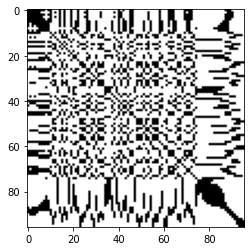

In [84]:
from matplotlib import pyplot as plt
img_num = 1
for i in range(img_num):
    plt.imshow(X[i], cmap='binary')
    plt.show()

## Model 훈련 및 결과

In [85]:
learning_rate = 1e-4
optimizer ='Adam'
loss='binary_crossentropy'
activation = 'sigmoid'
dimension = 4

In [86]:
from utils import split_data
X_train, X_test, Y_train, Y_test = split_data(X_scaled, X_scaled) #데이터 분리

In [87]:

from agent import Autoencoder_Agent
from keras import backend as K
import tensorflow as tf


autoencoder = Autoencoder_Agent(model_size=96, dimension=dimension, optimizer=optimizer,learning_rate=learning_rate,
                                activation_function=activation, loss_function=loss)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
activation_21 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 48, 48, 16)        4624      
_________________________________________________________________
activation_22 (Activation)   (None, 48, 48, 16)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 24, 24, 1)        

In [99]:
batch_size = 32
epochs = 100

In [100]:
hist = autoencoder.train(X_train, batch_size, epochs, X_test, early_stopping=False)

Epoch 1/100
32/32 [==============================] - 1s 22ms/step - loss: 0.5982 - val_loss: 0.5997
Epoch 2/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5982 - val_loss: 0.5998
Epoch 3/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5982 - val_loss: 0.5998
Epoch 4/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5982 - val_loss: 0.5998
Epoch 5/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5982 - val_loss: 0.5999
Epoch 6/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5982 - val_loss: 0.5998
Epoch 7/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5982 - val_loss: 0.5998
Epoch 8/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5982 - val_loss: 0.5998
Epoch 9/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5982 - val_loss: 0.5999
Epoch 10/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5982 - val_loss: 0.5998

32/32 [==============================] - 1s 21ms/step - loss: 0.5978 - val_loss: 0.5999
Epoch 83/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5978 - val_loss: 0.5999
Epoch 84/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5978 - val_loss: 0.5999
Epoch 85/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5978 - val_loss: 0.5999
Epoch 86/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5978 - val_loss: 0.6000
Epoch 87/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5978 - val_loss: 0.6000
Epoch 88/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5978 - val_loss: 0.5999
Epoch 89/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5978 - val_loss: 0.5999
Epoch 90/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5978 - val_loss: 0.5999
Epoch 91/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5977 - val_loss: 0.5999
Epo

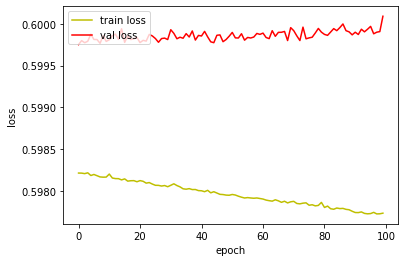

In [101]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()


loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
# loss_ax.plot([hist['loss'][i] - hist['val_loss'][i] for i in range(len(hist['loss']))], 'g', label='loss - val loss')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

### feature 추출

In [107]:
autoencoder.load('insectWing_dimension_4.h5')

In [108]:
# it = int(X_scaled.shape[0] / 30) 
all_feature = np.array(autoencoder.feature_extract(X_scaled))
# for i in range(1, it):
#     feature = autoencoder.feature_extract(X_scaled[i*30:(i+1)*30])
#     all_feature = np.concatenate([all_feature, feature])
print(all_feature)
print(all_feature.shape)

[[0.         1.196877   3.116687   3.0233476 ]
 [1.879636   2.0375051  4.480507   4.2682457 ]
 [0.58967936 1.4414824  2.9541326  3.7974887 ]
 ...
 [0.         0.7373688  1.0048702  4.356806  ]
 [1.0062858  2.4071512  2.5935786  4.0060987 ]
 [0.5692908  1.8011938  3.3414786  3.979414  ]]
(1330, 4)


## 군집화 및 군집 결과

In [109]:
from sklearn.cluster import KMeans
# Cluster Algorithm
cluster_result = KMeans(n_clusters=7).fit(all_feature)

In [110]:
labels_ = cluster_result.labels_ + 1
dic_labels_ = {}
for i in labels_:
    if f'{i}' not in dic_labels_.keys():
        dic_labels_[f'{i}'] = 1
    else:
        dic_labels_[f'{i}'] += 1

for key, value in dic_labels_.items():
    print(f"{key}: {value}")

5: 170
6: 81
2: 279
4: 288
1: 175
3: 217
7: 120


In [111]:
labels = [0, 1, 2,3, 4, 5, 6] * 190

In [112]:
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score(labels, cluster_result.labels_)

0.7316186752020896

### 실루엣 분석

In [67]:
result_reshaped = np.reshape(result_,(result_.shape[0],result_.shape[1]))

In [68]:
from sklearn.metrics import silhouette_samples,silhouette_score
def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km.labels_)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_score(X, y_km.labels_,metric='euclidean')
#     print(silhouette_vals)
    return silhouette_vals

res = plotSilhouette(result_reshaped,cluster_result)
print(res)

0.3662619448991662


### 추출 feature 값 결과

In [69]:
# 1. 해당 dimension 에서 100번 돌려서 제일 좋은 결과를 뽑는다.
cluster = 3
max_result = -1
for _ in range(100):
    cluster_result = KMeans(n_clusters=cluster).fit(all_feature)
    sil_res = plotSilhouette(result_reshaped, cluster_result)
    if max_result < sil_res:
        max_result = sil_res
print(f"군집 {cluster} 최대 실루엣 점수: {max_result}")

군집 3 최대 실루엣 점수: 0.3662619448991662


In [70]:
# 2. 1 ~ 100 군집 개수로 인한 결과 중에서 가장 좋은 결과를 뽑는다.
max_case_result = -1
max_case_cluster_n = 0
for i in range(2, 101):
    var_result = KMeans(n_clusters=i).fit(all_feature)
    sil_res = plotSilhouette(result_reshaped,var_result)
    if max_case_result < sil_res:
        max_case_result = sil_res
        max_case_cluster_n = i
print(f"최대 실루엣 점수: {max_case_result}\n군집개수: {max_case_cluster_n}")

최대 실루엣 점수: 0.4074238197108832
군집개수: 2


### 원 시계열 데이터 결과

In [71]:
# 1. 해당 dimension 에서 100번 돌려서 제일 좋은 결과를 뽑는다.
cluster = 3
max_result = -1
for _ in range(100):
    cluster_result = KMeans(n_clusters=cluster).fit(result_reshaped)
    sil_res = plotSilhouette(result_reshaped, cluster_result)
    if max_result < sil_res:
        max_result = sil_res
print(f"군집 {cluster} 최대 실루엣 점수: {max_result}")

군집 3 최대 실루엣 점수: 0.5165600068941217


In [72]:
# 2. 1 ~ 100 군집 개수로 인한 결과 중에서 가장 좋은 결과를 뽑는다.
max_case_result = -1
max_case_cluster_n = 0
for i in range(2, 101):
    var_result = KMeans(n_clusters=i).fit(result_reshaped)
    sil_res = plotSilhouette(result_reshaped,var_result)
    if max_case_result < sil_res:
        max_case_result = sil_res
        max_case_cluster_n = i
print(f"최대 실루엣 점수: {max_case_result}\n군집개수: {max_case_cluster_n}")

최대 실루엣 점수: 0.5212011838063243
군집개수: 4


In [77]:
from sklearn.cluster import KMeans
# Cluster Algorithm
cluster_result = KMeans(n_clusters=3).fit(result_reshaped)
res = plotSilhouette(result_reshaped,cluster_result)
print(res)

0.5165600068941217


In [76]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(result_reshaped, cluster_result.labels_)

0.9318125231359612

In [78]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(result_reshaped, cluster_result.labels_)

0.7628907660699906

In [81]:
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score([0, 0, 1, 1, 3, 2, 2], [1, 1,2, 2, 4, 3, 3])

1.0

In [80]:
normalized_mutual_info_score([0, 0,3, 2, 2, 1, 1], [0,2,  0, 1, 3, 2, 1])

0.5604873579836422